In [ ]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pickle

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
base_path = "."
words_list = []

words = open(f"{base_path}/words.txt","r").readlines()
for line in words:
  if line[0] == "#":
    continue
  if line.split(" ")[1] != "err":
    words_list.append(line)

print(len(words_list))
words_list = [entry for entry in words_list if 'r06-022-03-05 ok 184 924 1304 132 29 QL' not in entry]
print(len(words_list))
np.random.shuffle(words_list)

In [ ]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total training samples : {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total testing samples: {len(test_samples)}")


In [ ]:
base_image_path = os.path.join(base_path,"words")
def get_image_paths_and_labels(samples):
  paths = []
  corrected_samples = []
  for (i,file_line) in enumerate(samples):
    line_split = file_line.strip()
    line_split = line_split.split(" ")

    image_name = line_split[0]
    partI = image_name.split("-")[0]
    partII = image_name.split("-")[1]
    img_path = os.path.join(base_image_path,partI,partI+'-'+partII,image_name+".png")
    if os.path.getsize(img_path):
      paths.append(img_path)
      corrected_samples.append(file_line.split("\n")[0])
  return paths,corrected_samples

train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [ ]:
train_labels_cleaned=[]
characters = set()
max_len = 0

for label in train_labels:
  label = label.split(" ")[-1].strip()
  for char in label:
    characters.add(char)

  max_len = max(max_len,len(label))
  train_labels_cleaned.append(label)

print("maximum length: ",max_len)
print("Vocab size: ",len(characters))

In [ ]:
def clean_labels(labels):
  cleaned_labels = []
  for label in labels:
    label = label.split(" ")[-1].strip()
    cleaned_labels.append(label)
  return cleaned_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

RUN BELOW CELL IF RUNNING FOR FIRST TIME

In [ ]:
##if running model for first time run this cell to save the list of characters and use this save file for for next runs

# ff = list(characters)
# filename = 'characters_list.pkl'
# with open(filename, 'wb') as file:
#     pickle.dump(ff, file)

In [ ]:

# Load the list from the file
with open('characters_list.pkl', 'rb') as file:
    ff_loaded = pickle.load(file)

# Verify if the loaded list is the same as the original
print(ff_loaded)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

#mapping characters to integers
char_to_num = StringLookup(vocabulary = ff_loaded,mask_token = None)

#mapping integers back to original characters
num_to_char = StringLookup(
    vocabulary = char_to_num.get_vocabulary(),mask_token=None, invert = True
)

In [ ]:
def distortion_free_resize(image,img_size):
  w,h = img_size
  image = tf.image.resize(image,size=(h,w),preserve_aspect_ratio = True)

  #check the amount of padding needed to be done.
  pad_height = h - tf.shape(image)[0]
  pad_width = w - tf.shape(image)[1]

  # only necessary if you want to do same amount of padding on both sides.
  if pad_height % 2 != 0:
    height = pad_height // 2
    pad_height_top = height + 1
    pad_height_bottom = height
  else:
    pad_height_top = pad_height_bottom = pad_height//2
  if pad_width %2 != 0:
    width = pad_width//2
    pad_width_left = width + 1
    pad_width_right = width
  else:
    pad_width_left = pad_width_right = pad_width//2

  image = tf.pad(
      image,
      paddings = [
          [pad_height_top, pad_height_bottom],
          [pad_width_left, pad_width_right],
          [0,0],
      ],
  )

  image = tf.transpose(image, perm= [1,0,2])
  image = tf.image.flip_left_right(image)
  return image


In [ ]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size=(image_width,image_height)):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image,1)
  image = distortion_free_resize(image,img_size)
  image = tf.cast(image,tf.float32)/255.0
  return image

def vectorize_label(label):
  label = char_to_num(tf.strings.unicode_split(label,input_encoding = "UTF-8"))
  length = tf.shape(label)[0]
  pad_amount = max_len - length
  label = tf.pad(label, paddings = [[0,pad_amount]],constant_values=padding_token)
  return label

def process_images_labels(image_path,label):
  image = preprocess_image(image_path)
  label = vectorize_label(label)
  return{"image": image, "label" : label}

def prepare_dataset(image_paths, labels):
  dataset = tf.data.Dataset.from_tensor_slices((image_paths,labels)).map(
      process_images_labels,num_parallel_calls=AUTOTUNE
  )
  return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [ ]:
train_ds = prepare_dataset(train_img_paths,train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths,validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

In [ ]:
for data in train_ds.take(1):
  images,labels = data["image"],data["label"]
  _,ax=plt.subplots(4,4,figsize=(15,8))
  for i in range(16):
    img = images[i]
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img,perm=[1,0,2])
    img = (img * 255.0).numpy().clip(0,255).astype(np.uint8)
    img = img[:,:,0]

    #gather indices where label!=padding_token.
    label = labels[i]
    indices = tf.gather(label,tf.where(tf.math.not_equal(label,padding_token)))
    #convert to string
    label = tf.strings.reduce_join(num_to_char(indices))
    label = label.numpy().decode("utf-8")

    ax[i//4, i %4].imshow(img,cmap="gray")
    ax[i//4,i%4].set_title(label)
    ax[i//4,i%4].axis("off")

plt.show()

In [ ]:
class CTCLayer(keras.layers.Layer):
  def __init__(self,name=None):
    super().__init__(name=name)
    self.loss_fn = keras.backend.ctc_batch_cost

  def call(self,y_true,y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0],dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1],dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1],dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len,1),dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len,1),dtype="int64")
    loss = self.loss_fn(y_true,y_pred,input_length,label_length)
    self.add_loss(loss)

    return y_pred




In [ ]:
def build_model():
  #inputs to the model
  input_img = keras.Input(shape=(image_width,image_height,1),name = "image")
  labels = keras.layers.Input(name="label",shape = (None,))

  #first conv block
  x = keras.layers.Conv2D(
      32,
      (3,3),
      activation = "relu",
      kernel_initializer = "he_normal",
      padding = "same",
      name = "Conv1",
  )(input_img)
  x = keras.layers.MaxPooling2D((2,2),name = "pool1")(x)

  #second conv block
  x = keras.layers.Conv2D(
      64,
      (3,3),
      activation = "relu",
      kernel_initializer = "he_normal",
      padding = "same",
      name="Conv2"
  )(x)

  x = keras.layers.MaxPooling2D((2,2), name = "pool2")(x)

  new_shape = ((image_width//4),(image_height//4)*64)
  x = keras.layers.Reshape(target_shape = new_shape, name = "reshape")(x)
  x = keras.layers.Dense(64,activation ="relu",name = "dense1")(x)
  x = keras.layers.Dropout(0.2)(x)

  # RNNS
  x = keras.layers.Bidirectional(
      keras.layers.LSTM(128, return_sequences = True, dropout = 0.25)
  )(x)
  x = keras.layers.Bidirectional(
      keras.layers.LSTM(64,return_sequences = True, dropout = 0.25)
  )(x)

  # +2 to account for the two special tokens introduced by the CTC loss

  x = keras.layers.Dense(
      len(char_to_num.get_vocabulary()) + 2, activation = "softmax", name = "dense2"
  )(x)

  # add CTC layer for calculation ctc loss at each step
  output = CTCLayer(name="ctc_loss")(labels,x)

  #define the model
  model = keras.models.Model(
      inputs=[input_img,labels],outputs=output , name = "handwriting_recognizer"
  )

  #optimizer
  opt = keras.optimizers.Adam()

  #compile the model and return

  model.compile(optimizer=opt)
  return model


# get the model
model = build_model()
model.summary()

In [ ]:
validation_images = []
validation_labels = []

for batch in validation_ds:
  validation_images.append(batch["image"])
  validation_labels.append(batch["label"])


In [ ]:
def calculate_edit_distance(labels,predictions):
  saprse_labels = tf.cast(tf.sparse.from_dense(labels),dtype=tf.int64)

  input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
  predictions_decoded = keras.backend.ctc_decode(
      predictions,input_length = input_len, greedy=True
  )[0][0][:,:max_len]
  sparse_predictions = tf.cast(
      tf.sparse.from_dense(predictions_decoded),dtype = tf.int64
  )

  edit_distances = tf.edit_distance(
      sparse_predictions, saprse_labels, normalize = False
  )
  return tf.reduce_mean(edit_distances)

class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model, train_losses=None, val_losses=None, val_mean_edit_distance=None):
        super().__init__()
        self.prediction_model = pred_model
        self.train_losses = train_losses if train_losses is not None else []
        self.val_losses = val_losses if val_losses is not None else []
        self.val_mean_edit_distance = val_mean_edit_distance if val_mean_edit_distance is not None else []

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        mean_edit_distance = np.mean(edit_distances)
        self.val_mean_edit_distance.append(mean_edit_distance)
        self.train_losses.append(logs.get("loss"))
        self.val_losses.append(logs.get("val_loss"))
        print(
            f"Mean edit distance for epoch {epoch + 1}: {mean_edit_distance:.4f}"
        )

In [ ]:
epochs = 10
model = build_model()

In [ ]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name = "dense2").output
)

In [ ]:
edit_distance_callback = EditDistanceCallback(prediction_model)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs = epochs,
    callbacks =[edit_distance_callback],
)

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(edit_distance_callback.train_losses, label='Training Loss')
plt.plot(edit_distance_callback.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Save model
epochs_trained = 0
epochs_trained = epochs_trained + epochs
model.save('handwriting_recognizer.h5')
prediction_model.save('prediction.h5')
# Save loss values (train_losses and edit_distance_callback.val_losses)
np.savez(
    'loss_values.npz', train_losses=edit_distance_callback.train_losses, 
    val_losses=edit_distance_callback.val_losses,
    val_mean_edit_distance = edit_distance_callback.val_mean_edit_distance, 
    epochs_trained = epochs
    )

In [ ]:
def decode_batch_prediction(pred):
  input_len = np.ones(pred.shape[0]) * pred.shape[1]
  results = keras.backend.ctc_decode(pred,input_length = input_len, greedy = True)[0][0][:,:max_len]
  output_text = []
  for res in results:
    res = tf.gather(res,tf.where(tf.math.not_equal(res,-1)))
    res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
    output_text.append(res)
  return output_text

In [ ]:
# display the 1st 16 images from batch 1 on test data
for batch in test_ds.take(1):
  batch_images = batch["image"]
  _,ax = plt.subplots(4,4,figsize=(15,8))
  preds = prediction_model.predict(batch_images)
  pred_texts = decode_batch_prediction(preds)

  for i in range (16):
    img = batch_images[i]
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img,perm=[1,0,2])
    img = (img*255.0).numpy().clip(0,255).astype(np.uint8)
    img = img[:,:,0]

    title = f"Prediction: {pred_texts[i]}"
    ax[i//4,i%4].imshow(img,cmap="gray")
    ax[i//4,i%4].set_title(title)
    ax[i//4,i%4].axis("off")

  plt.show()

In [ ]:
def decode_single_prediction(pred):
    input_len = np.ones(1) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][0][:max_len]
    res = tf.gather(results, tf.where(tf.math.not_equal(results, -1)))
    return tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")

In [ ]:
# check on single image
my_img_path = 'Image_Path'
my_img = preprocess_image(my_img_path)
my_pred = prediction_model.predict(tf.expand_dims(my_img, axis=0))
predicted_text = decode_single_prediction(my_pred)
print(predicted_text)
img = tf.image.flip_left_right(my_img)
img = tf.transpose(img,perm=[1,0,2])
img = (img*255.0).numpy().clip(0,255).astype(np.uint8)
img = img[:,:,0]
plt.figure(figsize=(6, 6))  
plt.imshow(img, cmap='gray')  
plt.title(f'{predicted_text}')  
plt.axis('off')  
plt.show()

In [ ]:
def evaluate_test_set(test_ds, prediction_model, max_len):
    total_edit_distance = 0
    num_batches = 0

    for batch in test_ds:
        batch_images = batch["image"]
        batch_labels = batch["label"]
        preds = prediction_model.predict(batch_images)

        # Calculate edit distance for the current batch
        batch_edit_distance = calculate_edit_distance(batch_labels, preds)
        total_edit_distance += batch_edit_distance
        num_batches += 1

    mean_edit_distance = total_edit_distance / num_batches
    return mean_edit_distance

In [ ]:
# Evaluate model on test set by finding mean edit distance
test_mean_edit_distance = evaluate_test_set(test_ds, prediction_model, max_len)
print(f"Mean edit distance on test set: {test_mean_edit_distance:.4f}")

In [22]:
custom_objects = {'CTCLayer': CTCLayer}
with keras.utils.custom_object_scope(custom_objects):
    model = keras.models.load_model('saved models/handwriting_recognizer_50.h5')

# Load loss values
loss_data = np.load('saved models/loss_values_50.npz')
train_losses = loss_data['train_losses']
val_losses = loss_data['val_losses']
val_mean_edit_distance = loss_data['val_mean_edit_distance']
epochs_trained = loss_data['epochs_trained'].item()  # Load as integer

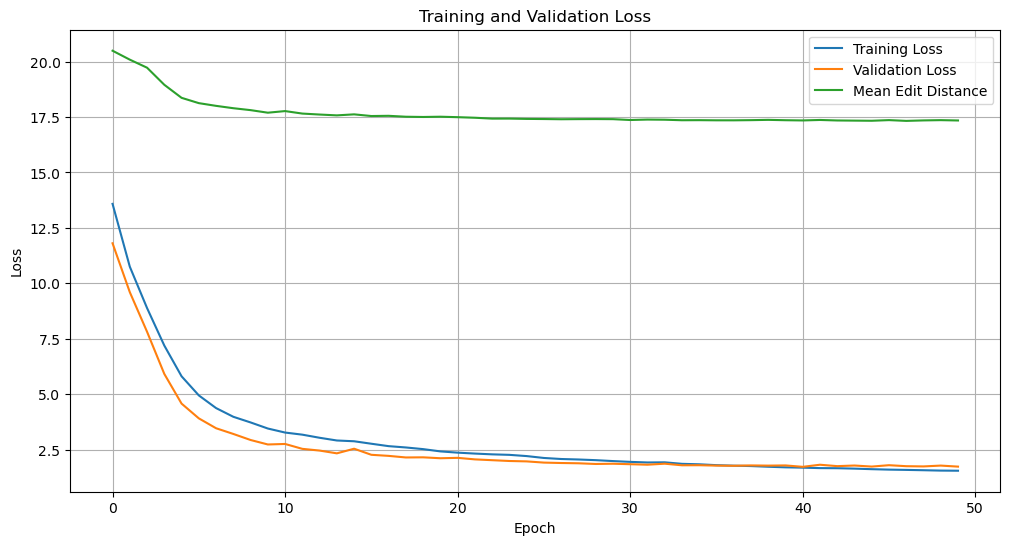

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.plot(val_mean_edit_distance,label='Mean Edit Distance')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig("loss-curve.png")
plt.show()
